In [1]:
import torch
import cv2
import numpy as np
import torchvision
import torch.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os

In [2]:
class fire(nn.Module):
    def __init__(self, inplanes, squeeze_planes, expand_planes):
        super(fire, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(squeeze_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=1, stride=1)
        self.bn2 = nn.BatchNorm2d(expand_planes)
        self.conv3 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(expand_planes)
        self.relu2 = nn.ReLU(inplace=True)

        # using MSR initilization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                m.weight.data.normal_(0, np.sqrt(2./n))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        out1 = self.conv2(x)
        out1 = self.bn2(out1)
        out2 = self.conv3(x)
        out2 = self.bn3(out2)
        out = torch.cat([out1, out2], 1)
        out = self.relu2(out)
        return out


class SqueezeNet(nn.Module):
    def __init__(self):
        super(SqueezeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1) # 32
        self.bn1 = nn.BatchNorm2d(96)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 16
        self.fire2 = fire(96, 16, 64)
        self.fire3 = fire(128, 16, 64)
        self.fire4 = fire(128, 32, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 8
        self.fire5 = fire(256, 32, 128)
        self.fire6 = fire(256, 48, 192)
        self.fire7 = fire(384, 48, 192)
        self.fire8 = fire(384, 64, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 4
        self.fire9 = fire(512, 64, 256)
        self.conv2 = nn.Conv2d(512, 4, kernel_size=1, stride=1)
        self.avg_pool = nn.AvgPool2d(kernel_size=4, stride=4)
        #self.softmax = nn.LogSoftmax(dim=1)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.fire2(x)
        x = self.fire3(x)
        x = self.fire4(x)
        x = self.maxpool2(x)
        x = self.fire5(x)
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.fire8(x)
        x = self.maxpool3(x)
        x = self.fire9(x)
        x = self.conv2(x)
        x = self.avg_pool(x)
        #x = self.softmax(x)
        return x

def fire_layer(inp, s, e):
    f = fire(inp, s, e)
    return f

def squeezenet(pretrained=False):
    net = SqueezeNet()
    # inp = Variable(torch.randn(64,3,32,32))
    # out = net.forward(inp)
    # print(out.size())
    return net

In [7]:
text_file = open(r'.\annotations.txt', "r").read().splitlines()
#text = text_file.readlines()
batch_size = 4
num_classes = 4
net  = SqueezeNet()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
for epoch in range(1):
    for i in range(len(text_file)):
        images = torch.zeros((batch_size,720,576,3))
        targets = torch.zeros(batch_size, 4)
        for s in range(2*batch_size):
            line = text_file[i+s]
            if line[-3:] == 'png':
                name = line
                name.rstrip('\n')
                print(name)
                image = torch.from_numpy(cv2.imread(name))
                means = (np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255))
                image = transforms.functional.normalize(image, means, (0,0,0))
                images[int(s/2)] = image
            else:
                target = np.fromstring(line, dtype = float, sep = ' ')
                targets[int(s/2)]=torch.from_numpy(target)
            i+=1
        net.train()
        images, targets = Variable(images), Variable(targets)

        # train the network
        optimizer.zero_grad()
        scores = net.forward(images)
        scores = scores.view(batch_size, num_classes)
        loss = F.nll_loss(scores, targets)

        # compute the accuracy
        pred = scores.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(targets.data).cpu().sum()

        avg_loss.append(loss.data[0])
        loss.backward()
        optimizer.step()

    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, loss.data[0]))

#     # also plot the loss, it should go down exponentially at some point
#     ax1.plot(avg_loss)
#     fig1.savefig("Squeezenet_loss.jpg")


.\images\ R177_SiGe_final_picture0.png


TypeError: expected np.ndarray (got NoneType)

TypeError: Image data cannot be converted to float

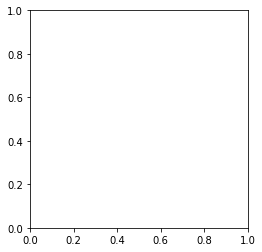

In [78]:
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.491399689874, 0.482158419622, 0.446530924224), (0.247032237587, 0.243485133253, 0.261587846975))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../', train=False, transform=transforms.Compose([
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.491399689874, 0.482158419622, 0.446530924224), (0.247032237587, 0.243485133253, 0.261587846975))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

# get the model and convert it into cuda for if necessary
net  = model.SqueezeNet()
if args.model_name is not None:
    print("loading pre trained weights")
    pretrained_weights = torch.load(args.model_name)
    net.load_state_dict(pretrained_weights)

if args.cuda:
    net.cuda()
#print(net)

# create optimizer
# using the 55 epoch learning rule here
def paramsforepoch(epoch):
    p = dict()
    regimes = [[1, 18, 5e-3, 5e-4],
               [19, 29, 1e-3, 5e-4],
               [30, 43, 5e-4, 5e-4],
               [44, 52, 1e-4, 0],
               [53, 1e8, 1e-5, 0]]
    # regimes = [[1, 18, 1e-4, 5e-4],
    #            [19, 29, 5e-5, 5e-4],
    #            [30, 43, 1e-5, 5e-4],
    #            [44, 52, 5e-6, 0],
    #            [53, 1e8, 1e-6, 0]]
    for i, row in enumerate(regimes):
        if epoch >= row[0] and epoch <= row[1]:
            p['learning_rate'] = row[2]
            p['weight_decay'] = row[3]
    return p

avg_loss = list()
best_accuracy = 0.0
fig1, ax1 = plt.subplots()


# train the model
# TODO: Compute training accuracy and test accuracy

# create a temporary optimizer
optimizer = optim.SGD(net.parameters(), lr=args.learning_rate, momentum=0.9, weight_decay=5e-4)

def adjustlrwd(params):
    for param_group in optimizer.state_dict()['param_groups']:
        param_group['lr'] = params['learning_rate']
        param_group['weight_decay'] = params['weight_decay']

# train the network


if __name__ == '__main__':
    if not args.want_to_test:
        fig2, ax2 = plt.subplots()
        train_acc, val_acc = list(), list()
        for i in xrange(1,args.epoch+1):
            train_acc.append(train(i))
            val_acc.append(val())
            ax2.plot(train_acc, 'g')
            ax2.plot(val_acc, 'b')
            fig2.savefig('train_val_accuracy.jpg')
    else:
        test_acc = test()
print("Testing accuracy on CIFAR-10 data is {:.2f}%".format(test_acc))